### Better implementation of multiple regression
Using the car price data and only the continuous variables.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
df = pd.read_csv("./datasets/CarPrice_Assignment.csv")
df.drop(columns=["car_ID", "CarName", "symboling"], index=1, inplace=True)
df_cont = df.select_dtypes(include="number")
print(df_cont.head())

   wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
0       88.6      168.8      64.1       48.8        2548         130   
2       94.5      171.2      65.5       52.4        2823         152   
3       99.8      176.6      66.2       54.3        2337         109   
4       99.4      176.6      66.4       54.3        2824         136   
5       99.8      177.3      66.3       53.1        2507         136   

   boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
0       3.47    2.68               9.0         111     5000       21   
2       2.68    3.47               9.0         154     5000       19   
3       3.19    3.40              10.0         102     5500       24   
4       3.19    3.40               8.0         115     5500       18   
5       3.19    3.40               8.5         110     5500       19   

   highwaympg    price  
0          27  13495.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  
5        

Let us look at correlation and VIF

### CORRELATION - part I

In [ ]:
# %pip install statsmodels

In [76]:
import statsmodels.api as sm


In [77]:
corr_vals = df_cont.corr()
# print(corr_vals)
corr_price = corr_vals.iloc[13, :]
corr_features = corr_price[abs(corr_price) > 0.6].index #ignoring features with -0.6 < rho < 0.6
print(corr_features)
# print(corr_features)
# 

Index(['carlength', 'carwidth', 'curbweight', 'enginesize', 'horsepower',
       'citympg', 'highwaympg', 'price'],
      dtype='object')


In [78]:
df_new = pd.DataFrame(df_cont, columns=corr_features)
print(df_new.head())

   carlength  carwidth  curbweight  enginesize  horsepower  citympg  \
0      168.8      64.1        2548         130         111       21   
2      171.2      65.5        2823         152         154       19   
3      176.6      66.2        2337         109         102       24   
4      176.6      66.4        2824         136         115       18   
5      177.3      66.3        2507         136         110       19   

   highwaympg    price  
0          27  13495.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  
5          25  15250.0  


In [79]:
X = df_new.iloc[:, :-1]
y = df_new[["price"]]

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [81]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1987)
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [82]:
regression = LinearRegression(fit_intercept=True, n_jobs = -1)
regression.fit(xtrain,ytrain)
ypred = regression.predict(xtest)


[-16868727.12693083 -23074289.36964466 -14184320.86377529
  -5323243.86977331  -9069500.61439895 -12669392.40619034
 -10655354.9334304   -9313889.55636283 -11717195.97715382
 -24457611.78371863]


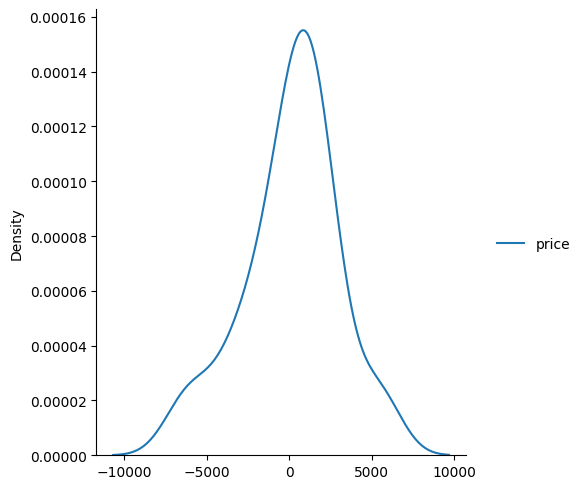

In [83]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(regression, xtrain, ytrain, scoring="neg_mean_squared_error", cv = 10)
print(cv_score)
ypred = regression.predict(xtest)
residual_vals = ypred-ytest
sns.displot(residual_vals, kind="kde")

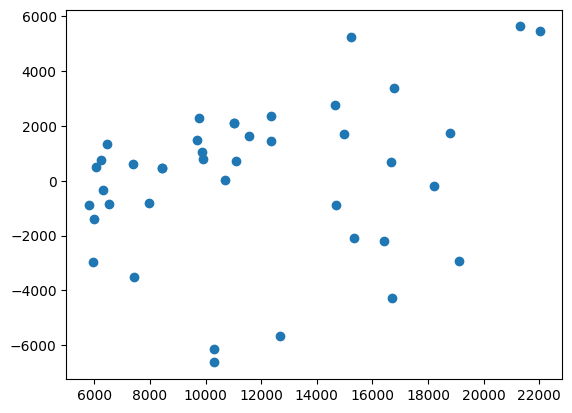

In [84]:
plt.scatter(ypred, residual_vals)

In [86]:
r2score = r2_score(ypred,ytest)
adjr2 = 1 - ((1-r2score) * len(ytest) - 1) / (len(ytest) - xtest.shape[1] - 1 )
# print(r2score)
# print(adjr2)
mse = mean_squared_error(ytest,ypred)
mae = mean_absolute_error(ytest,ypred)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, ypred)
print(f"Mean squared error: {mse}\nMean absolute error: {mae}\nR2: {r2}\nAdjusted R2: {adjr2}")
print(f"Regression coefficient: {regression.coef_}\nIntercept: {regression.intercept_}")

Mean squared error: 7865454.425944087
Mean absolute error: 2156.8395355421376
R2: 0.6288909339259994
Adjusted R2: 0.5524939458042286
Regression coefficient: [[ -83.00787472 1436.0711598  1249.3825536  3790.89119478 2273.37773673
   695.76649832 -435.33208504]]
Intercept: [13666.38752761]


Just by filtering out variables with low correlation gave poor fit.

Adjusted R2 with fitering = 0.553, without filtering = 0.57.

Therefore, retain all variables. Look at collinearity now

### COLLINEARITY - PART II

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

def calculate_VIF(df):
  df["intercept"] = 1
  vif_data = pd.DataFrame()
  vif_data["variables"] = df.columns
  vif_data['VIF'] = [VIF(df.values, i) for i in range(df.shape[1])]
  return vif_data


vif_vals = calculate_VIF(df_cont.iloc[:,:-1])
# print(vif_vals)
uncollinear_vars = vif_vals[vif_vals["VIF"] < 10]["variables"].values 
print(type(uncollinear_vars))
# uncollinear_vars = list(uncollinear_vars).append("price")
uncollinear_vars = np.append(uncollinear_vars, "price")
print(uncollinear_vars)

<class 'numpy.ndarray'>
['wheelbase' 'carlength' 'carwidth' 'carheight' 'enginesize' 'boreratio'
 'stroke' 'compressionratio' 'horsepower' 'peakrpm' 'price']


In [88]:
df_cont = df.select_dtypes(include="number")
df_small = pd.DataFrame(df_cont, columns=uncollinear_vars)
print(df_small.head())

   wheelbase  carlength  carwidth  carheight  enginesize  boreratio  stroke  \
0       88.6      168.8      64.1       48.8         130       3.47    2.68   
2       94.5      171.2      65.5       52.4         152       2.68    3.47   
3       99.8      176.6      66.2       54.3         109       3.19    3.40   
4       99.4      176.6      66.4       54.3         136       3.19    3.40   
5       99.8      177.3      66.3       53.1         136       3.19    3.40   

   compressionratio  horsepower  peakrpm    price  
0               9.0         111     5000  13495.0  
2               9.0         154     5000  16500.0  
3              10.0         102     5500  13950.0  
4               8.0         115     5500  17450.0  
5               8.5         110     5500  15250.0  


In [91]:
def runMLR(df):
  """A function to run multiple linear regression on a dataframe"""
  X = df.iloc[:, :-1]
  y = df[["price"]]
  xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1987)
  scaler = StandardScaler()
  xtrain = scaler.fit_transform(xtrain)
  xtest = scaler.transform(xtest)
  regression = LinearRegression(fit_intercept=True, n_jobs = -1)
  regression.fit(xtrain,ytrain)
  return regression, xtest, ytest
  
  
regModel, xtest2, ytest2 = runMLR(df_small)
# print(xtest2)
print(regModel.coef_)

[[ 717.01756683 -457.84185694 1333.94354294  565.64404594 5336.47120618
  -219.49215663 -801.27392667  952.81621213 2067.06962927 1172.12982238]]


In [93]:
def modelScoring(mod, xtest, ytest):
  """Scoring a regression model"""
  ypred = mod.predict(xtest)
  residual_vals = ypred-ytest
  r2score = r2_score(ypred,ytest)
  adjr2 = 1 - ((1-r2score) * len(ytest) - 1) / (len(ytest) - xtest.shape[1] - 1 )
  mse = mean_squared_error(ytest,ypred)
  mae = mean_absolute_error(ytest,ypred)
  rmse = np.sqrt(mse)
  # r2 = r2_score(ytest, ypred)
  print(f"Mean squared error: {mse}\nMean absolute error: {mae}\nR2: {r2score}\nAdjusted R2: {adjr2}")
  print(f"Regression coefficient: {regression.coef_}\nIntercept: {regression.intercept_}")
  
modelScoring(regModel, xtest2, ytest2)
  

Mean squared error: 6903294.447806446
Mean absolute error: 2116.4903506146693
R2: 0.6691344500203003
Adjusted R2: 0.5811504150277437
Regression coefficient: [[ -83.00787472 1436.0711598  1249.3825536  3790.89119478 2273.37773673
   695.76649832 -435.33208504]]
Intercept: [13666.38752761]
